#### Préliminaires

In [3]:
import numpy as np
import dicom
import imp
import scipy.ndimage as ndi
import scipy.misc as misc
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec
import scipy.interpolate as itp
import matplotlib.patches as patches
from IPython.display import YouTubeVideo
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D

In [4]:
%matplotlib notebook

In [5]:
nb_location = os.getcwd()

In [6]:
os.chdir("./full_set/")
dataset = os.getcwd()

In [7]:
os.chdir("../cardiacMRI/preprocessing/")

In [8]:
sources = os.getcwd()

In [9]:
import pp_execution as pp
import data_augmentation as daug
import dicom_geometry as dgm
import imp

***
# Arborescence des datasets
***

In [10]:
os.chdir(dataset)

***
**Pour un patient:**
* 0 ou 1 coupe **4ch**
* 0 ou 1 coupe **2ch**
* 8 à 12 coupes **sax**
***

In [11]:
full_slice_list = os.listdir("./")
full_slice_list

['2ch_52',
 '4ch_54',
 'sax_43',
 'sax_44',
 'sax_45',
 'sax_46',
 'sax_47',
 'sax_48',
 'sax_49',
 'sax_50']

***
(Hors cas dégénéré) 30 frames par coupe, **1 cycle cardiaque**
***

In [12]:
os.listdir(full_slice_list[0])

['IM-4018-0001.dcm',
 'IM-4018-0002.dcm',
 'IM-4018-0003.dcm',
 'IM-4018-0004.dcm',
 'IM-4018-0005.dcm',
 'IM-4018-0006.dcm',
 'IM-4018-0007.dcm',
 'IM-4018-0008.dcm',
 'IM-4018-0009.dcm',
 'IM-4018-0010.dcm',
 'IM-4018-0011.dcm',
 'IM-4018-0012.dcm',
 'IM-4018-0013.dcm',
 'IM-4018-0014.dcm',
 'IM-4018-0015.dcm',
 'IM-4018-0016.dcm',
 'IM-4018-0017.dcm',
 'IM-4018-0018.dcm',
 'IM-4018-0019.dcm',
 'IM-4018-0020.dcm',
 'IM-4018-0021.dcm',
 'IM-4018-0022.dcm',
 'IM-4018-0023.dcm',
 'IM-4018-0024.dcm',
 'IM-4018-0025.dcm',
 'IM-4018-0026.dcm',
 'IM-4018-0027.dcm',
 'IM-4018-0028.dcm',
 'IM-4018-0029.dcm',
 'IM-4018-0030.dcm']

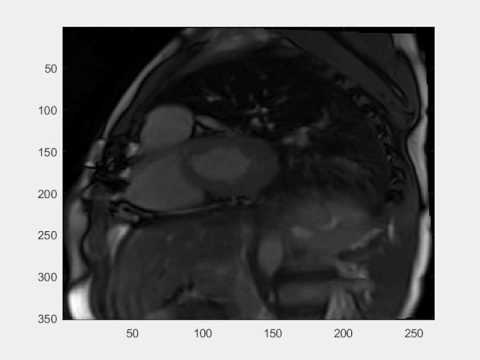

In [13]:
YouTubeVideo('UZcCp59Mafs')

In [14]:
f1 = "4ch_54/IM-4019-0001.dcm"
f2 = "2ch_52/IM-4018-0001.dcm"
f3 = "sax_45/IM-4012-0001.dcm"

***
# Format DICOM
***

In [15]:
ref1 = dicom.read_file(f1)

In [16]:
ref1

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'RETRO', 'NORM', 'DIS2D']
(0008, 0013) Instance Creation Time              TM: '142059.775000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.412872650511036751203263617890635675655
(0008, 0030) Study Time                          TM: '134011.232000'
(0008, 0031) Series Time                         TM: '142059'
(0008, 0032) Acquisition Time                    TM: '142053.087500'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'
(0008, 103e) Series Description                  LO: '4ch'
(0008, 1090) Manufacturer's Model Name           LO: 'Aera'
(0008, 1140)  Referenced Image Sequence   3 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: MR Image Storag

***
## Données image
***

<IPython.core.display.Javascript object>


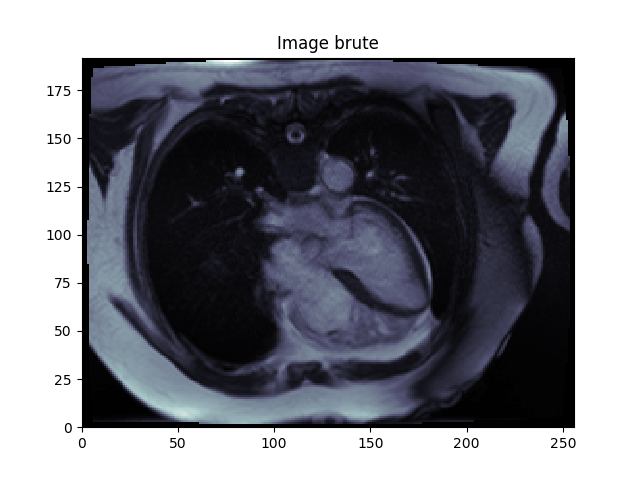

UNITES: PIXELS


In [17]:
im1 = ref1.pixel_array

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.pcolormesh(im1, cmap = 'bone')
ax1.set_title("Image brute")
ax1.set_aspect('equal')
plt.show()

print("UNITES: PIXELS")

***
## Données sur l'acquisition
***

**Échelles:**

In [18]:
dx1 = ref1.PixelSpacing[1]
dy1 = ref1.PixelSpacing[0]
print("Échelles en x et y: " + str(dx1) + " ; " + str(dy1))

Échelles en x et y: 1.40625 ; 1.40625


**Représentation paramétrique du plan d'acquisition:**

Origine: ['-166.16672438901', '-125.56374815723', '-67.378875512967']


Vecteurs de base: ['0.9989816983207', '3.6945631E-08', '-0.0451172519139'] 
 ['0.0221001745099', '0.8718126990316', '0.4893405767907']


<IPython.core.display.Javascript object>


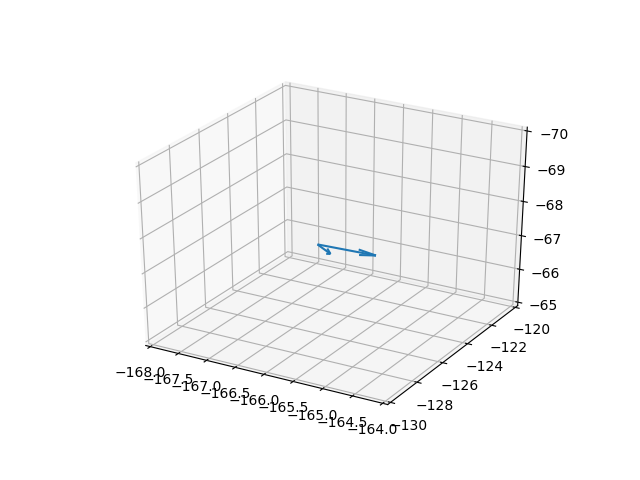

In [19]:
origin1 = ref1.ImagePositionPatient
u1 = ref1.ImageOrientationPatient[0:3]
v1 = ref1.ImageOrientationPatient[3:6]

print("Origine: " + str(origin1))
print("\n")
print("Vecteurs de base: " + str(u1) + " \n " + str(v1))

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.quiver(origin1[0], origin1[1], origin1[2], u1[0], u1[1], u1[2])
ax2.quiver(origin1[0], origin1[1], origin1[2], v1[0], v1[1], v1[2])

ax2.set_xlim([-168, -164])
ax2.set_ylim([-130, -120])
ax2.set_zlim([-65, -70])

plt.show()

# Redimensionnement

In [20]:
im1, x1, y1 = dgm.dicom_to_arrays(f1)
im2, x2, y2 = dgm.dicom_to_arrays(f2)
im3, x3, y3 = dgm.dicom_to_arrays(f3)

<IPython.core.display.Javascript object>


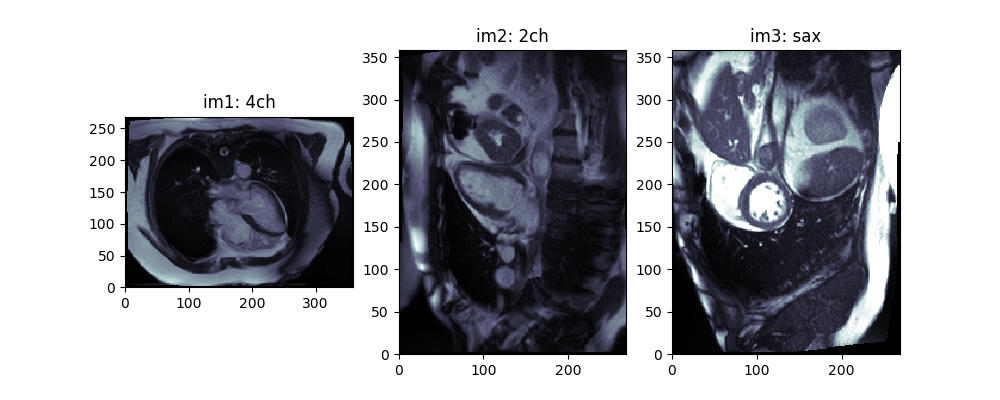

UNITES: mm


im1: taille (192, 256) ; resolution (1.40625, 1.40625) mm
im2: taille (256, 192) ; resolution (1.40625, 1.40625) mm
im3: taille (256, 192) ; resolution (1.40625, 1.40625) mm


In [21]:
fig3 = plt.figure(figsize=(10,4))
gs3 = gridspec.GridSpec(1,3)

ax3_1 = plt.subplot(gs3[0,0])
ax3_1.set_title("im1: 4ch")
ax3_1.pcolormesh(x1, y1, im1, cmap = 'bone')
ax3_1.set_aspect('equal')

ax3_2 = plt.subplot(gs3[0,1])
ax3_2.set_title("im2: 2ch")
ax3_2.pcolormesh(x2, y2, im2, cmap = 'bone')
ax3_2.set_aspect('equal')

ax3_3 = plt.subplot(gs3[0,2])
ax3_3.set_title("im3: sax")
ax3_3.pcolormesh(x3, y3, im3, cmap = 'bone')
ax3_3.set_aspect('equal')

plt.show()

print("UNITES: mm")
print("\n")
print("im1: taille " + str(im1.shape) + " ; resolution (" + str(x1[1]) + ", " + str(y1[1]) + ") mm")
print("im2: taille " + str(im2.shape) + " ; resolution (" + str(x2[1]) + ", " + str(y2[1]) + ") mm")
print("im3: taille " + str(im3.shape) + " ; resolution (" + str(x3[1]) + ", " + str(y3[1]) + ") mm")

In [22]:
ax3_3.clear()
ax3_3.set_title("im3: sax")
ax3_3.pcolormesh(x3, y3, daug.robust_contrast_stretching(im3), cmap = 'bone')
ax3_3.set_aspect('equal')

**Hétérogénéité inter-datasets:**

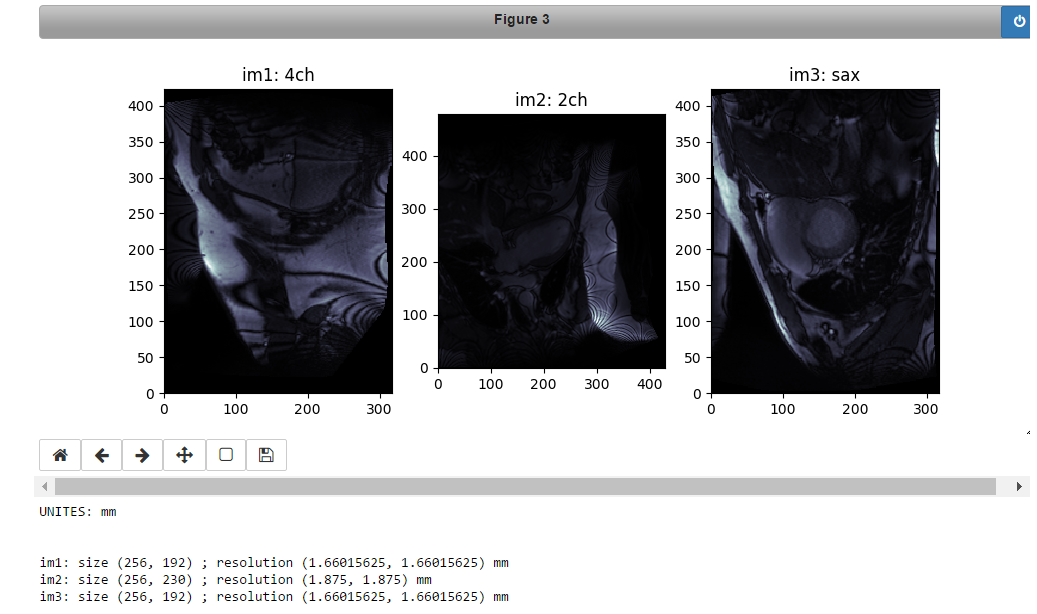

In [23]:
Image("../dataset_100.PNG")

***
**Objectif pour toutes les frames de tous les datasets:**

* Nombre de colonnes: $$ n_{x0} = 64$$ 
* Nombre de lignes: $$ n_{y0} = 64$$
* Largeur des colonnes: $$ d_{x0} = 1.6 \ mm$$
* Largeur des lignes: $$ d_{y0} = 1.6 \ mm$$
***

In [24]:
dx0 = 1.6
dy0 = 1.6
nx0 = 64
ny0 = 64

***
## Coupes "sax"
***

**Configuration des coupes:** alignement des coupes sax le long de l'axe 2ch x 4ch

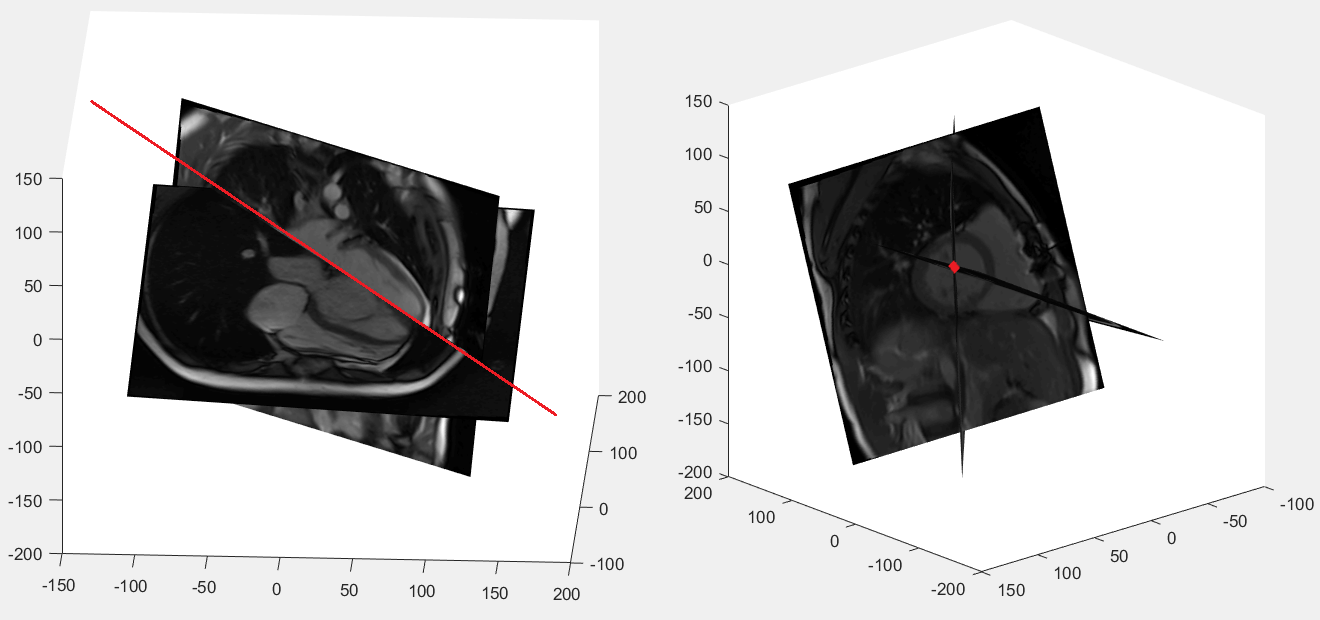

In [25]:
Image("../axe_myocarde.png")

** Passage représentation paramétrique - équation **

***
On dispose d'un plan défini par:

$$ \{ \vec{b} + k\vec{u} + p\vec{v} \ ; \ k, p \in R\} $$

On souhaiterait obtenir son équation:

$$ \vec{n} \cdot \vec{P} + d = 0 $$

Le vecteur normal au plan s'obtient facilement par **produit vectoriel**:

$$ \vec{n} = \vec{u} \times \vec{v} $$

puis:

$$ d = \vec{b} \cdot \vec{n} $$
***

In [26]:
p1 = dgm.locate_plane(f1)
p2 = dgm.locate_plane(f2)
p3 = dgm.locate_plane(f3)

print("Plan 4ch: " + str(p1))
print("Plan 2ch: " + str(p2))
print("Plan sax: " + str(p3))

Plan 4ch: (array([ 0.03933381, -0.48983938,  0.87092493]), -3.7118445058478855)
Plan 2ch: (array([-0.70406479, -0.69476818, -0.14693518]), -11.773022163907505)
Plan sax: (array([-0.74353497,  0.54721394,  0.38433403]), -48.949786798093797)


***
**Intersection de trois plans:**

$$ P_{0} = \frac{-d_{1}(n_{2} \times n_{3}) - d_{2}(n_{3} \times n_{1}) - d_{3}(n_{1} \times n_{2})}{-n_{1}\cdot(n_{2} \times n_{3})} $$
***

In [27]:
sax_center = dgm.three_plane_intersect(p1, p2, p3)
print("Position de l'intersection dans le repère 3D: " + str(sax_center))

Position de l'intersection dans le repère 3D: [ 41.14676168 -20.9640787  -17.91122774]


***
Passage dans le repère 2D du plan "sax":

$$ x_{0} = d_{x}\frac{\langle u \ | \ P_{0} \rangle}{d_{x0}} $$

$$ y_{0} = d_{y}\frac{\langle v \ | \ P_{0}  \rangle}{d_{y0}} $$

Puis arrondi à l'entier le plus proche.
***

<IPython.core.display.Javascript object>


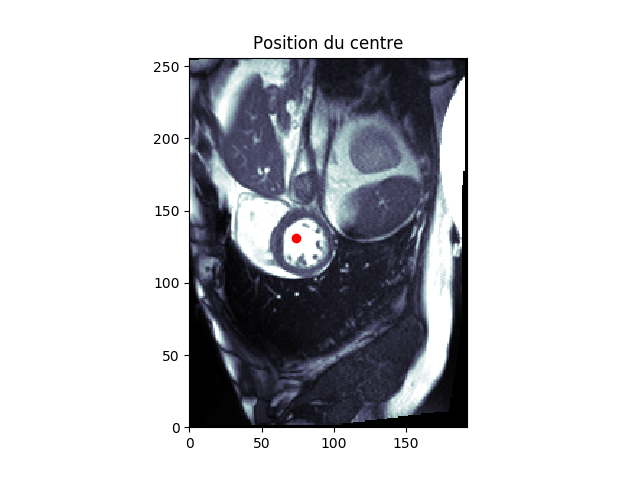

UNITES: PIXELS
Coordonnées de l'intersection dans le repère 2D: [74, 131]


In [28]:
cx3, cy3 = dgm.xyz_to_pixels(sax_center, f3)

fig4 = plt.figure()

ax4 = fig4.add_subplot(111)
ax4.pcolormesh(daug.robust_contrast_stretching(im3), cmap = 'bone')
ax4.scatter(cx3, cy3, color='Red')
ax4.set_title("Position du centre")
ax4.set_aspect('equal')
plt.show()

print("UNITES: PIXELS")

print("Coordonnées de l'intersection dans le repère 2D: " + str([cx3, cy3]))

***
**Rééchantillonnage:** par splines polynomiaux

**Fenêtre de recadrage:**
$$ [[ c_{x} - \frac{n_{x0}}{2}, c_{x} - \frac{n_{x0}}{2} ]] \\ \times \\ [[ c_{y} - \frac{n_{y0}}{2}, c_{y} - \frac{n_{y0}}{2} ]] $$
***

<IPython.core.display.Javascript object>


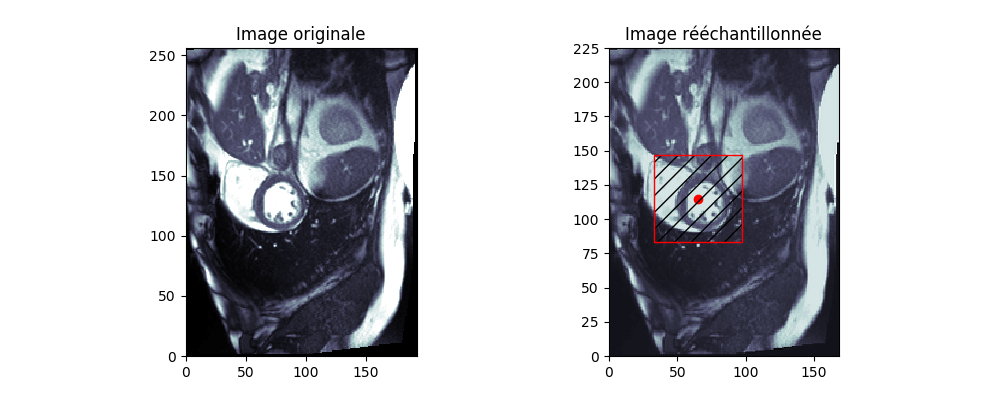

UNITES: PIXELS


In [29]:
fig5 = plt.figure(figsize=(10,4))
gs5 = gridspec.GridSpec(1,2)

ox3 = int(np.round(cx3 * x3[1] / dx0))
oy3 = int(np.round(cy3 * y3[1] / dy0))

x03 = np.arange(0.0, x3[-1], dx0)
y03 = np.arange(0.0, y3[-1], dy0)
interp_function = itp.RectBivariateSpline(y3, x3, daug.robust_contrast_stretching(im3))
z03 = interp_function(y03, x03)

ax5_1 = plt.subplot(gs5[0,0])
ax5_1.set_title("Image originale")
ax5_1.pcolormesh(daug.robust_contrast_stretching(im3), cmap = 'bone')
ax5_1.set_aspect('equal')

ax5_2 = plt.subplot(gs5[0,1])
ax5_2.set_title("Image rééchantillonnée")
ax5_2.pcolormesh(z03, cmap = 'bone')
ax5_2.scatter(ox3, oy3, color='Red')
ax5_2.add_patch(
    patches.Rectangle(
        (ox3 - nx0/2, oy3 - ny0/2),
        nx0,
        ny0,
        hatch = '//',
        fill=False,
        color='Red'
    )
)
ax5_2.set_aspect('equal')

plt.show()

print("UNITES: PIXELS")


<IPython.core.display.Javascript object>


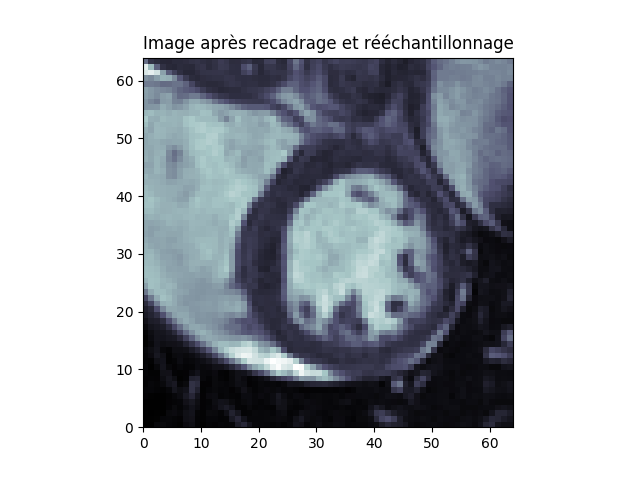

UNITES: PIXELS


In [30]:
im3_r = dgm.normalize_frame(im3, dx0, dy0, nx0, ny0, x3, y3, cx3, cy3)

fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.pcolormesh(im3_r, cmap = 'bone')
ax6.set_title("Image après recadrage et rééchantillonnage")
ax6.set_aspect('equal')
plt.show()

print("UNITES: PIXELS")

## Coupes "2ch" et "4ch"

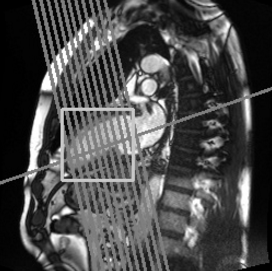

In [32]:
Image("../multiplane.PNG")

***
* Intersections avec **tous** les plans "sax"
* **Barycentre** des intersections
***

In [33]:
sax_list = [os.path.join(x, os.listdir(x)[0]) for x in os.listdir(dataset) if "sax" in x]
l = []
for sax_slice in sax_list:
    p_sax = dgm.locate_plane(sax_slice)
    itsc = dgm.three_plane_intersect(p1, p2, p_sax)
    l.append(itsc)
    
ch_center = np.sum(np.array(l),axis=0)/len(sax_list)
print("Centre du ventricule gauche dans le repère 3D: " + str(ch_center))

Centre du ventricule gauche dans le repère 3D: [ 51.52212532 -30.27200968 -23.61492684]


***
Passage dans les repères 2ch, 4ch:
***

<IPython.core.display.Javascript object>


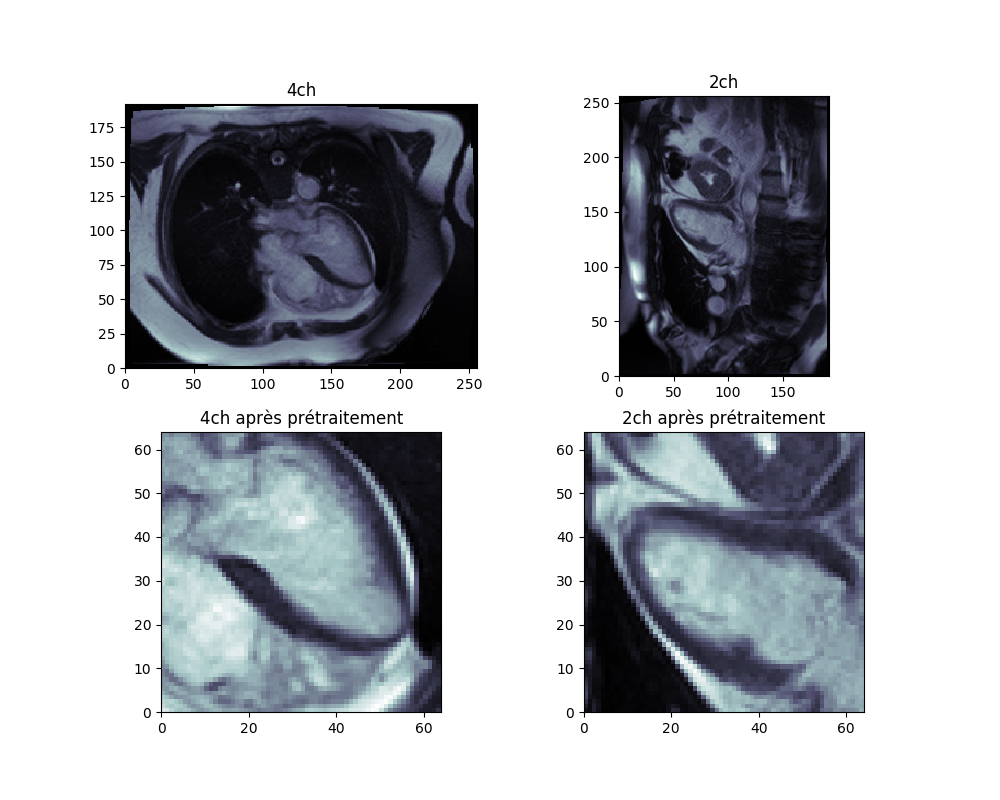

UNITES: PIXELS


In [34]:
cx1, cy1 = dgm.xyz_to_pixels(ch_center, f1)
cx2, cy2 = dgm.xyz_to_pixels(ch_center, f2)

im1_r = pp.apply_normalization(dx0, dy0, nx0, ny0, f1, cx1, cy1)
im2_r = pp.apply_normalization(dx0, dy0, nx0, ny0, f2, cx2, cy2)

fig7 = plt.figure(figsize=(10,8))
gs7 = gridspec.GridSpec(2,2)

ax7_1 = plt.subplot(gs7[0,0])
ax7_1.set_title("4ch")
ax7_1.pcolormesh(im1, cmap = 'bone')
ax7_1.set_aspect('equal')

ax7_2 = plt.subplot(gs7[0,1])
ax7_2.set_title("2ch")
ax7_2.pcolormesh(im2, cmap = 'bone')
ax7_2.set_aspect('equal')

ax7_3 = plt.subplot(gs7[1,0])
ax7_3.set_title("4ch après prétraitement")
ax7_3.pcolormesh(im1_r, cmap = 'bone')
ax7_3.set_aspect('equal')

ax7_3 = plt.subplot(gs7[1,1])
ax7_3.set_title("2ch après prétraitement")
ax7_3.pcolormesh(im2_r, cmap = 'bone')
ax7_3.set_aspect('equal')

plt.show()

print("UNITES: PIXELS")

***
# Contraste
***

* Contraste médiocre sur les images originales
* Solution: étirer les intensités sur la gamme des niveaux de gris disponibles
* Problème: **artefacts**
* Pour un CNN, risque de concentration des activations autour des artefacts

<IPython.core.display.Javascript object>


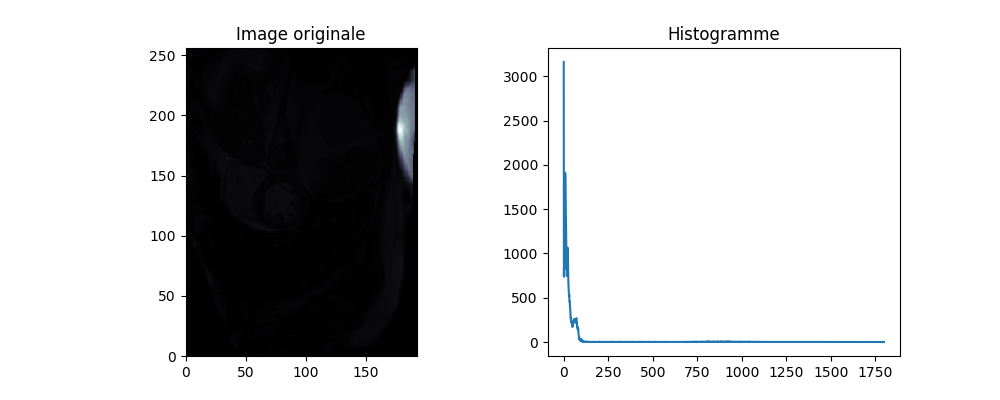

In [35]:
hist0,bins0 = np.histogram(im3, np.arange(0,1800,1))

fig8 = plt.figure(figsize=(10,4))
gs8 = gridspec.GridSpec(1,2)

ax8_1 = plt.subplot(gs8[0,0])
ax8_1.set_title("Image originale")
ax8_1.pcolormesh(im3, cmap = 'bone')
ax8_1.set_aspect('equal')

ax8_2 = plt.subplot(gs8[0,1])
ax8_2.set_title("Histogramme")
ax8_2.plot(bins0[0:1799], hist0)

plt.show()

<IPython.core.display.Javascript object>


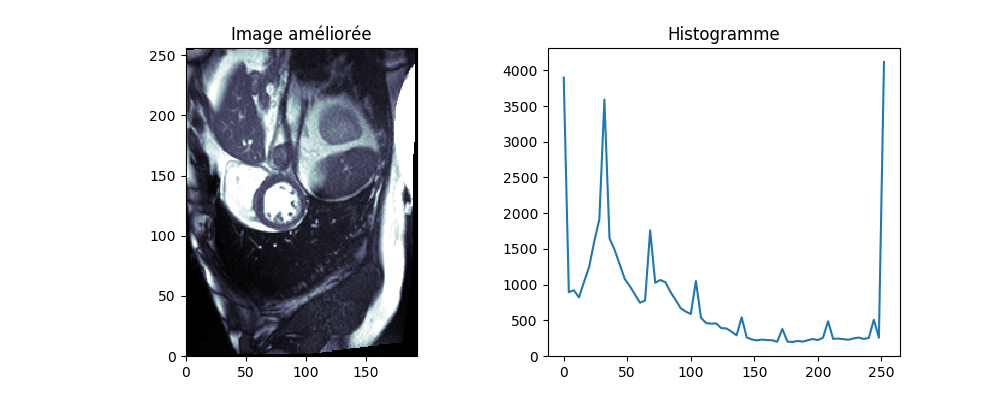

In [36]:
hist1,bins1 = np.histogram(daug.robust_contrast_stretching(im3), np.arange(0,257,4))

fig9 = plt.figure(figsize=(10,4))
gs9 = gridspec.GridSpec(1,2)

ax9_1 = plt.subplot(gs9[0,0])
ax9_1.set_title("Image améliorée")
ax9_1.pcolormesh(daug.robust_contrast_stretching(im3), cmap = 'bone')
ax9_1.set_aspect('equal')

ax9_2 = plt.subplot(gs9[0,1])
ax9_2.set_title("Histogramme")
ax9_2.plot(bins1[0:64], hist1)

plt.show()

# Data Augmentation

**Principe:** produire des datasets synthétiques en transformant ceux dont on dispose

***
## Tensor rolling

*Permutation cyclique des frames*

Frames importantes à l'estimation proches de:
* la fin de diastole
* la fin de systole
***

***
## Rotation
***

<IPython.core.display.Javascript object>


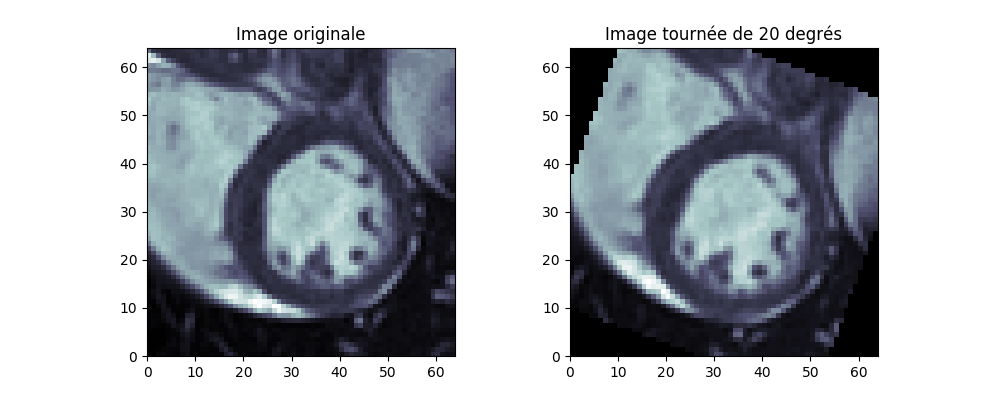

In [37]:
im3_r_rot = ndi.rotate(im3_r, 20, reshape = False)

fig10 = plt.figure(figsize=(10,4))
gs10 = gridspec.GridSpec(1,2)

ax10_1 = plt.subplot(gs10[0,0])
ax10_1.set_title("Image originale")
ax10_1.pcolormesh(im3_r, cmap = 'bone')
ax10_1.set_aspect('equal')

ax10_2 = plt.subplot(gs10[0,1])
ax10_2.set_title("Image tournée de 20 degrés")
ax10_2.pcolormesh(im3_r_rot, cmap = 'bone')
ax10_2.set_aspect('equal')

plt.show()

***
## Glissement

Transformation affine 2D correspondant à la matrice:

$$ 
M = \begin{pmatrix}
1 & k \\
0 & 1
\end{pmatrix}
$$

Remarque: $$ det(M) = 1$$

***

<IPython.core.display.Javascript object>


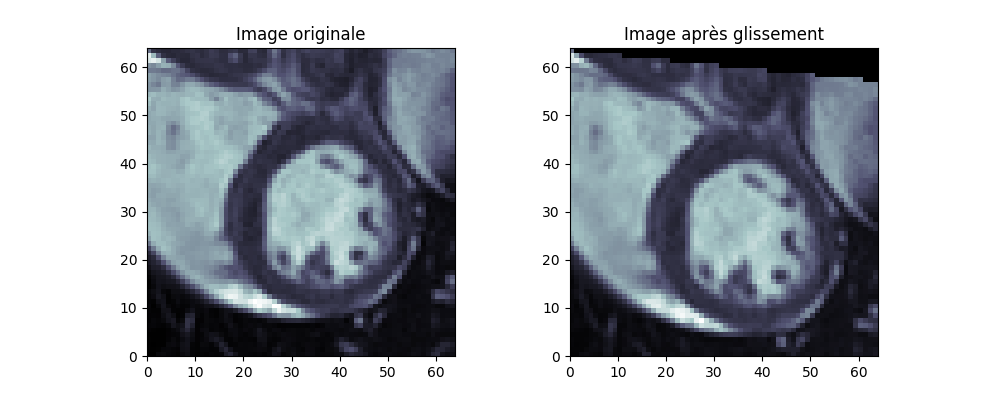

In [38]:
im3_r_g = daug.skew_x(im3_r, 0.1)

fig11 = plt.figure(figsize=(10,4))
gs11 = gridspec.GridSpec(1,2)

ax11_1 = plt.subplot(gs11[0,0])
ax11_1.set_title("Image originale")
ax11_1.pcolormesh(im3_r, cmap = 'bone')
ax11_1.set_aspect('equal')

ax11_2 = plt.subplot(gs11[0,1])
ax11_2.set_title("Image après glissement")
ax11_2.pcolormesh(im3_r_g, cmap = 'bone')
ax11_2.set_aspect('equal')

plt.show()